In [116]:
# %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [117]:
import numpy as np
import pandas as pd

In [118]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [119]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [120]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [121]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [122]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [123]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [124]:
# Create our session (link) from Python to the DB
session = Session(engine)
#Get column headings for later in the excercise
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [125]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Calculate the date 1 year ago from the last data point in the database
year_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
precip_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_date).\
order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precip_scores, columns=['Date', 'Prcp'])
# Sort the dataframe by date
precipitation_df['Date']=pd.to_datetime(precipitation_df.Date)
precipitation_df.sort_values("Date",inplace = True)
precipitation_df.head()

,Date,Prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


<function matplotlib.pyplot.show(*args, **kw)>

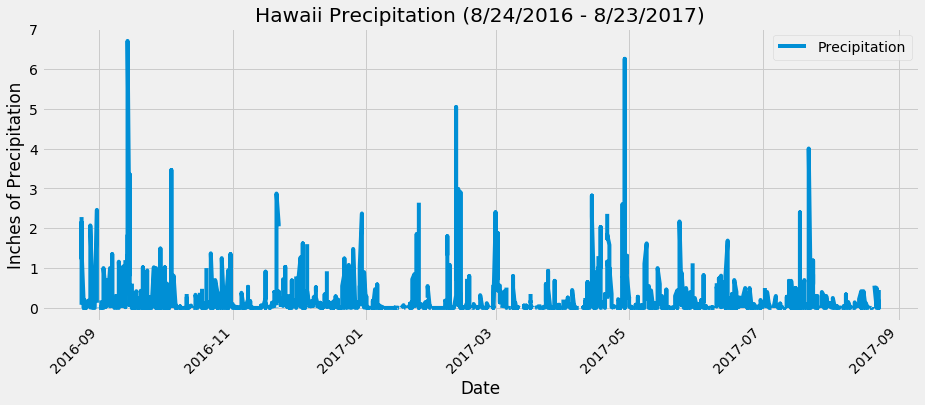

In [126]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot('Date', 'Prcp',figsize=(14, 6))
plt.xlabel("Date")
plt.ylabel("Inches of Precipitation")
plt.title("Hawaii Precipitation (8/24/2016 - 8/23/2017)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.savefig("images/precipitation-js.png")
plt.show

In [127]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [29]:
# Design a query to show how many stations are available in this dataset?
#Get column headings for later in the excercise
station_total = session.query(Measurement).group_by(Measurement.station).count()
print(f"There are {station_total} stations in this dataset".format(station_total))

There are 9 stations in this dataset


In [39]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station))\
            .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [49]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_activity[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

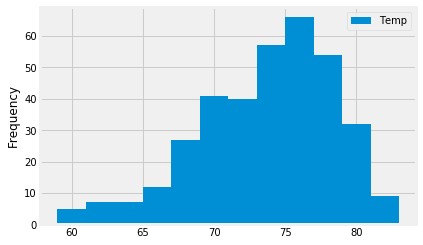

In [80]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
recent_date_active = session.query(Measurement.date)\
                            .filter(Measurement.station == active_stations[0][0])\
                            .order_by(Measurement.date.desc()).first()
# Convert string to datetime
string_date = dt.datetime.strptime(recent_date_active[0], "%Y-%m-%d").date()

# Calculate one year ago
twelve_months = string_date - dt.timedelta(days=365)
# Query for temperature history
temperature = session.query(Measurement.date, Measurement.tobs)\
                        .filter(Measurement.date >= twelve_months, Measurement.station == active_stations[0][0]).all()

# Turn into dataframe
temp_df = pd.DataFrame(temperature, columns=['Date', 'Temp'])
# Sort by date
temp_df.sort_values("Date",inplace = True)
# Plot as histogram
temp_df.plot.hist(bins=12)
plt.savefig("images/temp_freq-js.png")

In [74]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [75]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-06-01','2017-06-10'))

[(72.0, 77.546875, 81.0)]


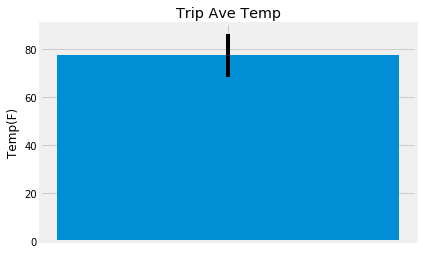

<Figure size 432x288 with 0 Axes>

In [105]:
# Plot the results from your previous query as a bar chart. 
#selecting the trip date as June 1st, 2018 to June 10th, 2018
triptemps = calc_temps('2017-06-01','2017-06-10')
triptemps_df = pd.DataFrame(triptemps, columns=['Tmin', 'Tavg', 'Tmax'])
triptemps_df
Tmin = triptemps_df.iloc[0,0]
Tavg = triptemps_df.iloc[0,1]
Tmax = triptemps_df.iloc[0,2]
plt.figure
x = 1
plt.bar(x,Tavg, tick_label="", yerr=Tmax-Tmin)
plt.title("Trip Ave Temp")
plt.ylabel("Temp(F)")
plt.show()
plt.savefig("images/trip_temp-js.png")
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [112]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_start = '2017-06-01'
trip_end = '2017-06-10'

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
result = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= trip_start).\
    filter(Measurement.date <= trip_end).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print (result)
rainfall_df = pd.DataFrame(result, columns=['Station', 'Name', 'Latitude','Longitude','Elevation','Total'])
rainfall_df

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.99), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.92), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.85), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.73), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.28), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.06), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


,Station,Name,Latitude,Longitude,Elevation,Total
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.99
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.92
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.85
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.73
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.28
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.06
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
